In [15]:
import sys
import os

# Add the parent directory (project root) to the Python path
# This allows you to import modules from the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


from src.gmm_msb import GMMmSB
from sklearn.mixture import GaussianMixture
import torch
from third_party.plot_confidence_region import *
import matplotlib.pyplot as plt
import torchsde
from matplotlib.lines import Line2D

In [5]:
data = np.load('../data/processed_data.npz', allow_pickle=True)

In [6]:
data_list = list(list(data.values())[0].item().values())

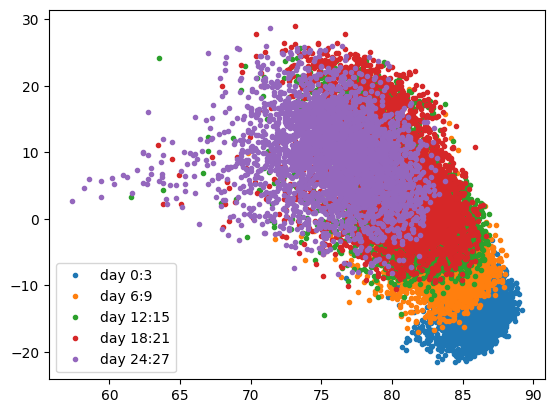

In [7]:
for yy in data_list:
    plt.plot(yy[:, 0], yy[:, 1], '.')

plt.legend(['day ' + str(i) + ':' + str(i+3) for i in [0, 6, 12, 18, 24]])

In [8]:
d_data = 5 # Fits GMMs to 4 marginals

# To train from scratch, uncomment:
# mix = []
# for data_t in data_list:
#     mix.append(GaussianMixture(n_components=5, covariance_type='full', random_state=0).fit(data_t[:, 0:d_data]))
#
# Mu = [rho.means_ for rho in mix]
# S = [rho.covariances_ for rho in mix]
# W  = [rho.weights_ for rho in mix]
#
# GMMS = GMMmSB(S=S, Mu=Mu, W=W, eps=0.01, nt=5, nt_fine=100, Lambda=None, nbatch=0)

# Use the precomputed L, S, Mu, W to save some training time
data = torch.load('../data/5d_data.pt', weights_only=False)
L = data['L']
S = data['S']
Mu = data['Mu']
W = data['W']
GMMS = GMMmSB(S=S, Mu=Mu, W=W, eps=0.01, nt=5, nt_fine=100, Lambda=L, nbatch=0) # this will only compute the active policies given the precomputed Lambda

100%|██████████| 21/21 [03:11<00:00,  9.11s/it]


In [11]:
X0 = torch.tensor(data_list[0][0:2000, 0:d_data], dtype=torch.float32)
X0_full = GMMS.fill_vel(X0, 0.)
t = torch.tensor(GMMS.T_fine)

0


In [13]:
# t = torch.linspace(0, 3., 100)
y = torchsde.sdeint(GMMS, X0_full, t, method='euler', dt = t.diff()[0])

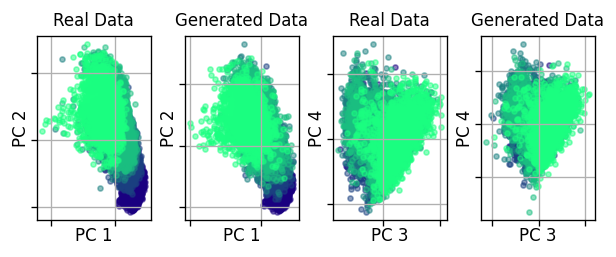

In [24]:
# %matplotlib inline

fig, axs = plt.subplots(1, 4)
fig.set_size_inches(6, 2)
traj = y.numpy()

# col = ['blue', 'orange', 'green', 'red', 'purple']
col = [(0.1, tau, 0.5, 0.5) for tau in np.linspace(0, 1, 5)]

for a in axs.flatten():
    a.grid('on')

ax = axs.flatten()

for data_t, c in zip(data_list, col):
    ax[0].plot(data_t[0:2000, 0], data_t[0:2000, 1], '.', color = c, zorder=-1)
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[0].set_xlabel("PC 1", labelpad=-3, fontsize=10)
    ax[0].set_ylabel("PC 2", labelpad=-3, fontsize=10)
    ax[0].set_title("Real Data", fontsize=10)
    # ax[0][0].legend(['t1', 't2', 't3', 't4'])

for data_t, c in zip(data_list, col):
    ax[2].plot(data_t[0:2000, 2], data_t[0:2000, 3], '.', color = c, zorder=-1)
    ax[2].set_xticklabels([])
    ax[2].set_yticklabels([])
    ax[2].set_xlabel("PC 3", labelpad=-3, fontsize=10)
    ax[2].set_ylabel("PC 4", labelpad=-3, fontsize=10)
    ax[2].set_title("Real Data", fontsize=10)

for data_t, c in zip(y[::GMMS.nt_fine], col):
    ax[1].plot(data_t[:, 0], data_t[:, 1], '.', color = c, zorder=-1)
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_ylabel("PC 2", labelpad=-3, fontsize=10)
    ax[1].set_xlabel("PC 1", labelpad=-3, fontsize=10)
    ax[1].set_title("Generated Data", fontsize=10)


for data_t, c in zip(y[::GMMS.nt_fine], col):
    ax[3].plot(data_t[:, 2], data_t[:, 3], '.', color = c, zorder=-1)
    ax[3].set_xticklabels([])
    ax[3].set_yticklabels([])
    ax[3].set_ylabel("PC 4", labelpad=-3, fontsize=10)
    ax[3].set_xlabel("PC 3", labelpad=-3, fontsize=10)
    ax[3].set_title("Generated Data", fontsize=10)

fig.subplots_adjust(wspace=0.3)
# fig.tight_layout()
fig.savefig('../figures/scRNAseq_5d.png')

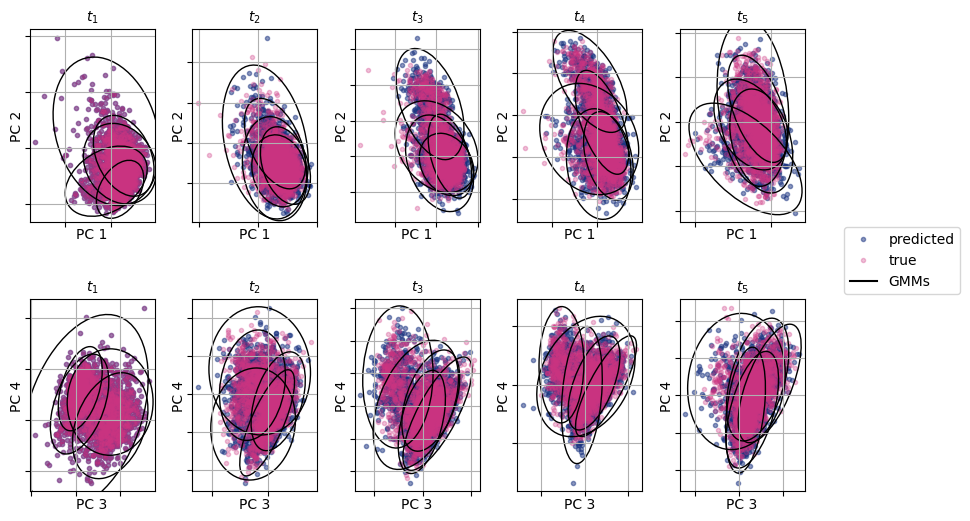

In [16]:
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(10, 6)
traj = y.numpy()

# col = ['blue', 'orange', 'green', 'red', 'purple']
col1 = [(0.1, 0.2, 0.5, 0.5) for tau in np.linspace(0, 1, 5)]
col2 = [(0.8, 0.2, 0.5, 0.5) for tau in np.linspace(0, 1, 5)]

for a in axs.flatten():
    a.grid('on')

for i, (data_t, data_pred, c1, c2, si, mui) in enumerate(zip(data_list, y[::GMMS.nt_fine], col1, col2, S, Mu)):

    axs[0][i].plot(data_pred[0:2000, 0], data_pred[0:2000, 1], '.', color = c1, zorder=-1, label='predicted', alpha=0.5)
    axs[0][i].plot(data_t[0:2000, 0], data_t[0:2000, 1], '.', color = c2, zorder=-1, label='true', alpha=0.3)

    axs[0][i].set_xticklabels([])
    axs[0][i].set_yticklabels([])
    axs[0][i].set_xlabel("PC 1", labelpad=-3, fontsize=10)
    axs[0][i].set_ylabel("PC 2", labelpad=-3, fontsize=10)
    axs[0][i].set_title("$t_" + str(i+1) + '$', fontsize=10)
    # axs[0][i].legend(['pred', 'true'], fontsize=10)

    axs[1][i].plot(data_pred[0:2000, 2], data_pred[0:2000, 3], '.', color = c1, zorder=-1, alpha=0.5)
    axs[1][i].plot(data_t[0:2000, 2], data_t[0:2000, 3], '.', color = c2, zorder=-1, alpha=0.3)

    axs[1][i].set_xticklabels([])
    axs[1][i].set_yticklabels([])
    axs[1][i].set_xlabel("PC 3", labelpad=-3, fontsize=10)
    axs[1][i].set_ylabel("PC 4", labelpad=-3, fontsize=10)
    axs[1][i].set_title("$t_" + str(i+1) + '$', fontsize=10)
    # axs[1][i].legend(['pred', 'true'], fontsize=10)

    for s, m in zip(si, mui):
        confidence_ellipse(axs[0][i], cov=s[0:2, 0:2], mean=m[0:2], edgecolor='k', linewidth=1)
        confidence_ellipse(axs[1][i], cov=s[2:4, 2:4], mean=m[2:4], edgecolor='k', linewidth=1)

line = Line2D([0], [0], label='GMMs', color='k')

axs[0][0].legend()
handles, labels = axs[0][0].get_legend_handles_labels()

handles.extend([line])
axs[0][0].legend(handles=handles, fontsize=10, bbox_to_anchor = (7.5, -0.2), loc='center right')


fig.subplots_adjust(wspace=0.3, hspace=0.4)
# fig.tight_layout()
# fig.savefig('figures/scRNAseq_5d_details.png', bbox_inches='tight')

## Calculate a few performance indices

In [17]:
from ot.sliced import sliced_wasserstein_distance, max_sliced_wasserstein_distance

class MMD_loss(torch.nn.Module):
    '''
    fork from: https://github.com/ZongxianLee/MMD_Loss.Pytorch
    '''

    def __init__(self, kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0 - total1) ** 2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples ** 2 - n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num,
                                       fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY - YX)
        return loss

mmd = MMD_loss()

In [18]:
data_tens = torch.stack([torch.tensor(tens[0:2000, 0:5], dtype=torch.float32) for tens in data_list])
# y_sample = torch.stack([GMMS.sample_rho(tau, 2000) for tau in GMMS.T_fine[::GMMS.nt_fine] ])
# y_sample = torch.stack([torch.tensor(rho.sample(2000)[0], dtype=torch.float32) for rho in mix])
y_sample = y[::GMMS.nt_fine, 0:2000, 0:5]

In [19]:
n_metric = 2000
d_data = 5
swd_list = []
mmd_list = []
for pred, ref in zip(y[::GMMS.nt_fine], data_tens):
    swd = sliced_wasserstein_distance(pred[0:n_metric, 0:d_data], ref[0:n_metric, 0:d_data])
    swd_list.append(swd)

    mmd_val = mmd(pred[0:n_metric, 0:d_data], ref[0:n_metric, 0:d_data]).item()
    mmd_list.append(mmd_val)

    print(swd, mmd_val)

print('AVERAGE : ', np.stack(swd_list[1:]).mean(), np.stack(mmd_list[1:]).mean())

tensor(0.) 0.0
tensor(0.2902) 0.0025854567065835
tensor(0.3908) 0.003785734763368964
tensor(0.3946) 0.003919723443686962
tensor(0.3266) 0.002574944170191884
AVERAGE :  0.35054457 0.0032164647709578276


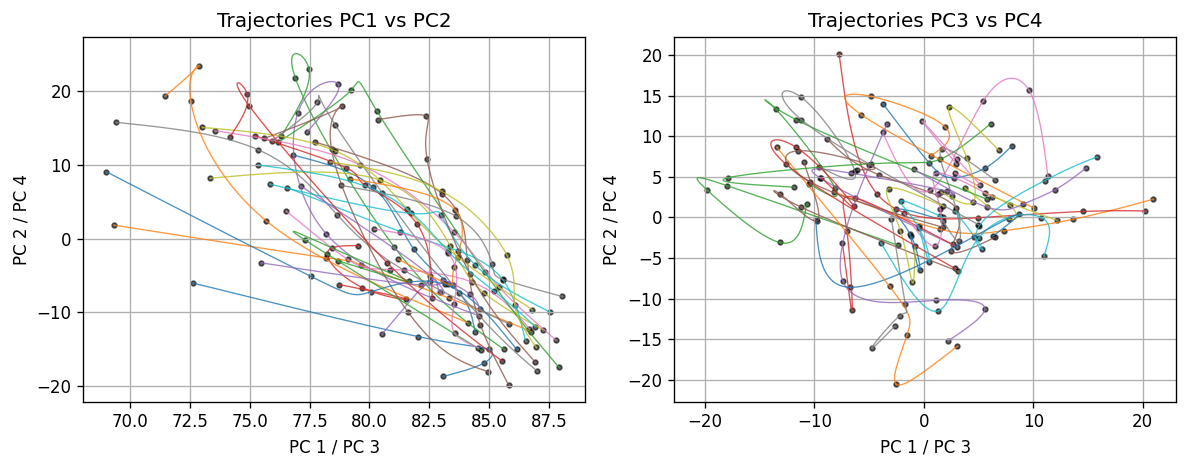

In [20]:
# Visualize a handful of sample trajectories from the generated SDE solution 'y'
# y has shape (n_time, n_particles, dim). We'll plot a subset of particles across time in the PC1-PC2 plane and PC3-PC4 plane.
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
n_show = 30  # how many trajectories to show
time_idx = np.linspace(0, y.shape[0]-1, 5, dtype=int)  # choose 5 snapshot times for markers
traj = y.numpy()  # (T, N, D)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title('Trajectories PC1 vs PC2')
axes[1].set_title('Trajectories PC3 vs PC4')
# pick evenly spaced particle indices
N = traj.shape[1]
idx = np.linspace(0, N-1, min(n_show, N), dtype=int)
for i in idx:
    axes[0].plot(traj[:, i, 0], traj[:, i, 1], linewidth=0.8, alpha=0.8)
    axes[1].plot(traj[:, i, 2], traj[:, i, 3], linewidth=0.8, alpha=0.8)
# overlay markers at selected times
for t in time_idx:
    axes[0].scatter(traj[t, idx, 0], traj[t, idx, 1], s=8, color='k', alpha=0.6)
    axes[1].scatter(traj[t, idx, 2], traj[t, idx, 3], s=8, color='k', alpha=0.6)
for a in axes:
    a.set_xlabel('PC 1 / PC 3')
    a.set_ylabel('PC 2 / PC 4')
    a.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Create an animation of the marginal densities (PC1-PC2) over time and save as GIF/MP4.
# We'll compute 2D histograms for the first two PCs and use matplotlib.animation.FuncAnimation to build the animation.
import matplotlib
from matplotlib import animation
import tempfile
# prepare histogram grid based on combined extents
data_all = traj[:, :, 0:2].reshape(-1, 2)
xmin, ymin = data_all.min(axis=0) - 1e-6
xmax, ymax = data_all.max(axis=0) + 1e-6
nbins = 100
xedges = np.linspace(xmin, xmax, nbins)
yedges = np.linspace(ymin, ymax, nbins)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Marginal density PC1-PC2 over time')
# initial histogram
H, xedges_, yedges_ = np.histogram2d(traj[0, :, 0], traj[0, :, 1], bins=[xedges, yedges], density=True)
im = ax.imshow(H.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='viridis', aspect='auto')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(im, ax=ax)
def update(frame):
    H, _, _ = np.histogram2d(traj[frame, :, 0], traj[frame, :, 1], bins=[xedges, yedges], density=True)
    im.set_data(H.T)
    ax.set_title(f'Marginal density PC1-PC2 (t={frame})')
    return (im,)
anim = animation.FuncAnimation(fig, update, frames=range(0, traj.shape[0], max(1, traj.shape[0]//60)), interval=200, blit=True)
# save to a temporary file (requires imagemagick or ffmpeg installed)
out_path_gif = '../figures/marginal_pc1_pc2.gif'
out_path_mp4 = '../figures/marginal_pc1_pc2.mp4'
try:
    anim.save(out_path_mp4, writer='ffmpeg', dpi=150)
    print('Saved animation to', out_path_mp4)
except Exception as e:
    print('Could not save mp4 (ffmpeg missing?), trying gif fallback:', e)
    try:
        anim.save(out_path_gif, writer='imagemagick', dpi=80)
        print('Saved animation to', out_path_gif)
    except Exception as e2:
        print('Failed to save animation:', e2)
plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


Could not save mp4 (ffmpeg missing?), trying gif fallback: unknown file extension: .mp4
Saved animation to ../figures/marginal_pc1_pc2.gif


In [23]:
# Additional animation for PC3-PC4 with imageio fallback (robust saving)
import imageio
# prepare grid for PC3-PC4
data_all_34 = traj[:, :, 2:4].reshape(-1, 2)
xmin34, ymin34 = data_all_34.min(axis=0) - 1e-6
xmax34, ymax34 = data_all_34.max(axis=0) + 1e-6
nbins = 100
xedges34 = np.linspace(xmin34, xmax34, nbins)
yedges34 = np.linspace(ymin34, ymax34, nbins)
frames = list(range(0, traj.shape[0], max(1, traj.shape[0]//60)))
png_frames = []
fig, ax = plt.subplots(figsize=(4,4))
for f in frames:
    H, _, _ = np.histogram2d(traj[f, :, 2], traj[f, :, 3], bins=[xedges34, yedges34], density=True)
    im = ax.imshow(H.T, origin='lower', extent=(xmin34, xmax34, ymin34, ymax34), cmap='viridis', aspect='auto')
    ax.set_title(f'PC3-PC4 t={f}')
    ax.set_xlabel('PC3')
    ax.set_ylabel('PC4')
    plt.tight_layout()
    tmpfile = f'_frame_{f}.png'
    fig.savefig(tmpfile, dpi=100)
    png_frames.append(tmpfile)
    ax.clear()
plt.close(fig)
# Try to write GIF via imageio (no external writer required)
out_gif = '../figures/marginal_pc3_pc4.gif'
with imageio.get_writer(out_gif, mode='I', duration=0.2) as writer:
    for fname in png_frames:
        image = imageio.v2.imread(fname)
        writer.append_data(image)
print('Saved PC3-PC4 animation to', out_gif)
# Optionally remove temporary png frames to save disk space
import os
for fname in png_frames:
    try:
        os.remove(fname)
    except Exception:
        pass

Saved PC3-PC4 animation to ../figures/marginal_pc3_pc4.gif
